### Projet

In [4]:
pip install SPARQLWrapper scikit-learn matplotlib


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [5]:
from SPARQLWrapper import SPARQLWrapper, JSON

def getSPARQLQuery():
    sparql_endpoint = "https://query.wikidata.org/sparql"
    sparql = SPARQLWrapper(sparql_endpoint)
    sparql.setQuery("""
    SELECT ?item ?itemLabel ?image {
    ?item wdt:P31 wd:Q144;  
            wdt:P18 ?image.  
    SERVICE wikibase:label { bd:serviceParam wikibase:language "fr". }
    }""")

    sparql.setReturnFormat(JSON)
    res = sparql.query().convert()

    dog_array = []
    for result in res["results"]["bindings"]:
        dog_array.append(tuple((
            result["itemLabel"]["value"],
            result["image"]["value"])
        ))
    return dog_array

array = getSPARQLQuery()

In [6]:
import pandas as pd

dataframe = pd.DataFrame(array, columns=["dog_name", "image"])
dataframe = dataframe.astype(
    dtype={"dog_name": "<U200", "image" : "<U200"}
)
dataframe["image"] = dataframe["image"].str.ljust(100)
print(dataframe)

               dog_name                                              image
0    Sallie Ann Jarrett  http://commons.wikimedia.org/wiki/Special:File...
1             Q20818039  http://commons.wikimedia.org/wiki/Special:File...
2             Q21002371  http://commons.wikimedia.org/wiki/Special:File...
3             Q21978595  http://commons.wikimedia.org/wiki/Special:File...
4                Kabosu  http://commons.wikimedia.org/wiki/Special:File...
..                  ...                                                ...
150     Primley Sceptre  http://commons.wikimedia.org/wiki/Special:File...
151          Q121549125  http://commons.wikimedia.org/wiki/Special:File...
152          Q123588410  http://commons.wikimedia.org/wiki/Special:File...
153                 Pep  http://commons.wikimedia.org/wiki/Special:File...
154               Messi  http://commons.wikimedia.org/wiki/Special:File...

[155 rows x 2 columns]


In [7]:
import requests
import os
from builtins import open


output_directory = 'images'
if not os.path.exists(output_directory):
    os.makedirs(output_directory)


def download_image(image_url, output_directory):
    headers={'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/102.0.0.0 Safari/537.36'}
    response = requests.get(image_url, headers=headers)
    print(image_url)
    if response.status_code == 200:
        image_filename = output_directory + "/" + os.path.basename(image_url)
        try :
            with open(image_filename, 'wb') as f:
                f.write(response.content)
            print(f"Image téléchargée avec succès : {image_url}")
        except Exception as e :
            print(e)
    else:
        print(f"Échec du téléchargement. Code d'état HTTP : {response.status_code}")


for index, row in dataframe.iterrows():
    image_url = row['image']
    download_image(image_url, output_directory)

http://commons.wikimedia.org/wiki/Special:FilePath/Sallie%20Ann%20Jarrett%2C%20Civil%20War%20mascot.jpg
Image téléchargée avec succès : http://commons.wikimedia.org/wiki/Special:FilePath/Sallie%20Ann%20Jarrett%2C%20Civil%20War%20mascot.jpg
http://commons.wikimedia.org/wiki/Special:FilePath/Tuna%20Melts%20My%20Heart.jpg                    
Image téléchargée avec succès : http://commons.wikimedia.org/wiki/Special:FilePath/Tuna%20Melts%20My%20Heart.jpg                    
http://commons.wikimedia.org/wiki/Special:FilePath/Doug%20the%20Pug%20NYC.jpg                       
Image téléchargée avec succès : http://commons.wikimedia.org/wiki/Special:FilePath/Doug%20the%20Pug%20NYC.jpg                       
http://commons.wikimedia.org/wiki/Special:FilePath/Teddy%2C%20dog%20in%20silent%20film%20comedies%20%28SAYRE%209685%29.jpg
Image téléchargée avec succès : http://commons.wikimedia.org/wiki/Special:FilePath/Teddy%2C%20dog%20in%20silent%20film%20comedies%20%28SAYRE%209685%29.jpg
http://commons

In [8]:
import json
import os
from PIL import Image, ExifTags
from PIL.TiffImagePlugin import IFDRational  # Required for serializing EXIF data

# Define the directory where your images are saved
image_directory = 'images'
metadata_output_file = 'image_metadata.json'

# Function to handle non-serializable data types for JSON
def convert_if_not_serializable(o):
    if isinstance(o, bytes):
        return o.decode('utf-8', 'ignore')
    elif isinstance(o, IFDRational):
        return f"{o.numerator}/{o.denominator}"
    else:
        return str(o)

# Function to get EXIF data and convert non-serializable parts
def get_exif_data(img):
    exif_data = {}
    info = img._getexif()
    if info:
        for tag, value in info.items():
            key = ExifTags.TAGS.get(tag, tag)
            exif_data[key] = convert_if_not_serializable(value)
    return exif_data

# Function to determine image orientation
def get_image_orientation(width, height):
    if width > height:
        return 'Landscape'
    elif width < height:
        return 'Portrait'
    else:
        return 'Square'

# Function to save metadata to a JSON file
def save_metadata(metadata_list, output_file):
    with open(output_file, 'w') as json_file:
        json.dump(metadata_list, json_file, default=convert_if_not_serializable, indent=4)

# Create a list to hold metadata dictionaries
image_metadata_list = []

# List of valid image file extensions
valid_image_extensions = {".jpg", ".jpeg", ".png", ".gif", ".bmp", ".tiff"}

# Process each image file in the directory
for image_filename in os.listdir(image_directory):
    # Check if the file is an image based on its extension
    if image_filename.lower().endswith(tuple(valid_image_extensions)):
        image_path = os.path.join(image_directory, image_filename)
        if os.path.isfile(image_path):
            with Image.open(image_path) as img:
                metadata = {
                    'image_name': image_filename,
                    'image_size': img.size,
                    'image_format': img.format,
                    'image_orientation': get_image_orientation(img.width, img.height),
                    'exif_data': get_exif_data(img)
                }
                image_metadata_list.append(metadata)

# Save the metadata list to a JSON file
save_metadata(image_metadata_list, os.path.join(image_directory, metadata_output_file))


C:\Users\ewanc\AppData\Local\Temp\ipykernel_12572\1567489990.py:33: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  return image.resize(size, Image.ANTIALIAS)


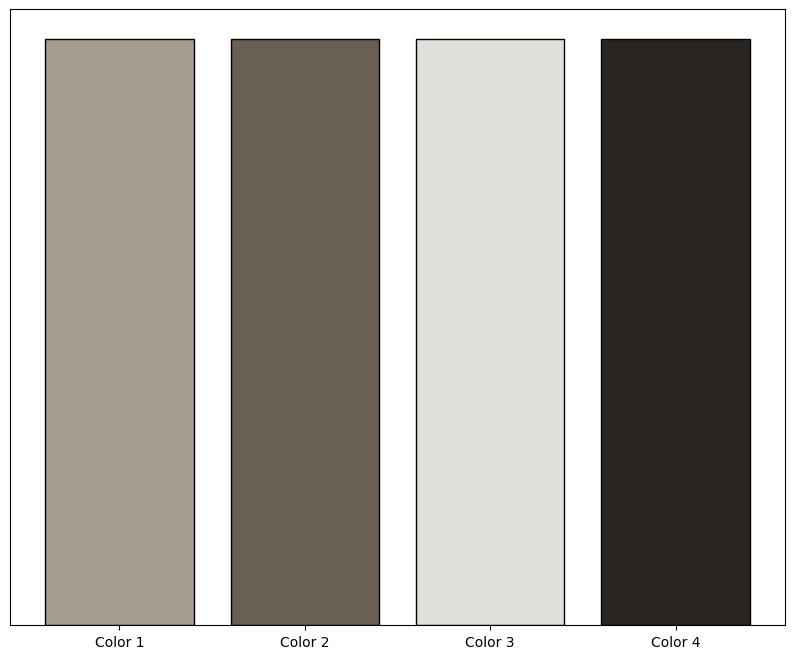

New processed metadata stored successfully.


In [6]:
import json
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from PIL import Image


#we are getting the average color of all images here to tag them otherwise especially via user input
#it would be too long to do it for each image but the idea is the same, 


# Load original metadata
with open('images/image_metadata.json') as f:
    images_metadata = json.load(f)

# Function to convert RGB color to hex
def convert_color_to_hex(color):
    return '#{:02x}{:02x}{:02x}'.format(int(color[0]), int(color[1]), int(color[2]))

# Function to find predominant colors using KMeans clustering
def find_dominant_colors(image_np, num_colors=4):
    kmeans = KMeans(n_clusters=num_colors)
    kmeans.fit(image_np)
    colors = kmeans.cluster_centers_
    return colors

# Function to downsample an image to reduce memory usage
def downsample_image(image, max_size=256):
    """Downsample the image to reduce its size."""
    factor = min(max_size / max(image.size), 1)
    size = int(factor * image.size[0]), int(factor * image.size[1])
    return image.resize(size, Image.ANTIALIAS)

# Function to check if the file is an image based on its extension
def is_image_file(filename):
    valid_image_extensions = ['.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff', '.webp']
    return any(filename.lower().endswith(ext) for ext in valid_image_extensions)


def plot_color_bars(colors, counts):
    # Create an empty figure and axis to plot on
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Create a bar for each color with the correct color and height
    for i, (color, count) in enumerate(zip(colors, counts)):
        ax.bar(i, count, color=np.clip(color, 0, 255) / 255, edgecolor='black')
    
    # Set the x-ticks to correspond to the bars
    plt.xticks(range(len(colors)), [f'Color {i+1}' for i in range(len(colors))])
    plt.yticks([])  # Hide y-ticks
    
    # Show the plot
    plt.show()





# Collect all colors from all images
all_colors = np.array([]).reshape(0, 3)

for metadata in images_metadata:
    image_name = metadata['image_name']
    if not is_image_file(image_name):
        continue  # Skip files that aren't images

    image_path = os.path.join('images', image_name)
    with Image.open(image_path) as img:
        # Ensure the image is in RGB mode and downsample it
        if img.mode != 'RGB':
            img = img.convert('RGB')
        img = downsample_image(img)
        image_np = np.array(img)
        all_colors = np.vstack((all_colors, image_np.reshape((-1, 3))))

# Find the 4 most dominant colors across all images
dominant_colors = find_dominant_colors(all_colors, num_colors=4)
hex_colors = [convert_color_to_hex(color) for color in dominant_colors]

# Plot dominant colors
plot_color_bars(dominant_colors, [1]*4)  # We just want to show colors, so count is 1

# Process each image and update metadata with the common dominant colors and the 'dog' tag
processed_images_metadata = []
for metadata in images_metadata:
    # Append new data to the processed_images_metadata list
    processed_images_metadata.append({
        'image_name': metadata['image_name'],
        'dominant_colors': hex_colors,  # The common dominant colors
        'user_tags': ['dog']  # The 'dog' tag
    })

# Save the new processed metadata to a separate JSON file
new_metadata_file_path = 'images/processed_image_metadata.json'
with open(new_metadata_file_path, 'w') as f:
    json.dump(processed_images_metadata, f, indent=4)

print("New processed metadata stored successfully.")


The most common favorite color is: ('#a59d8f', 50)
The most common favorite orientation is: ('Square', 23)
The most common favorite size is: ('Thumbnail', 14)
The most common favorite tag is: ('dog', 50)

Example user profile:
{
    "favorite_colors": {
        "#a59d8f": 5,
        "#695f53": 5,
        "#e0dfda": 5,
        "#28241f": 5
    },
    "favorite_orientations": {
        "Square": 3,
        "Portrait": 2
    },
    "favorite_sizes": {
        "Medium": 3,
        "Thumbnail": 2
    },
    "favorite_tags": {
        "dog": 5
    }
}


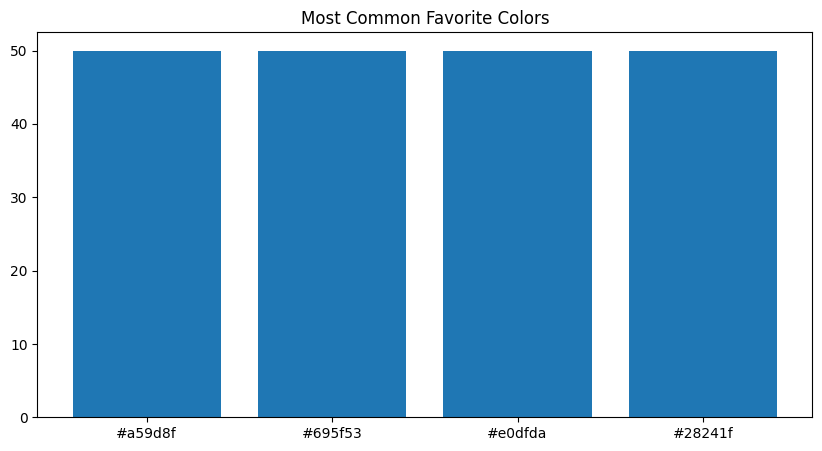

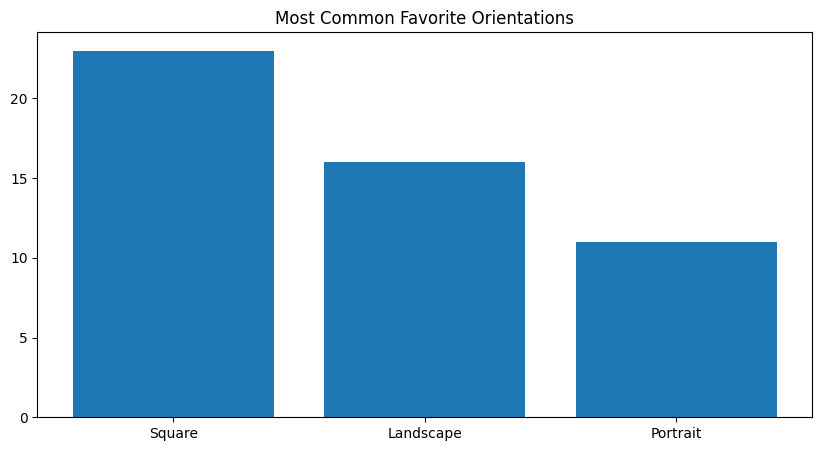

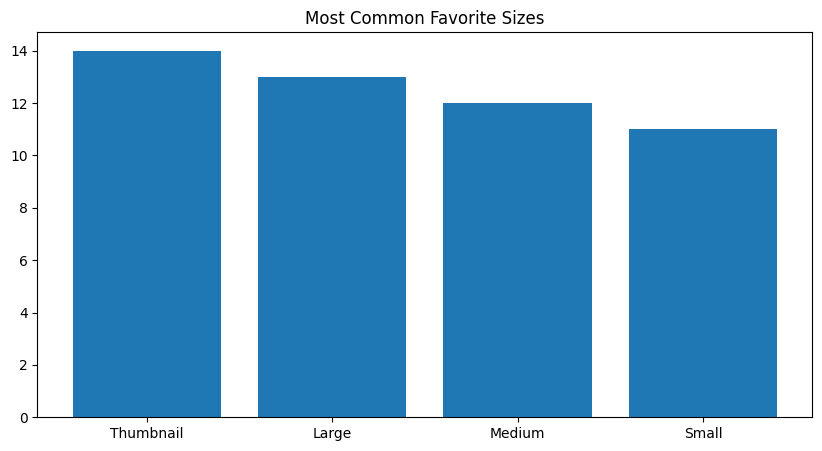

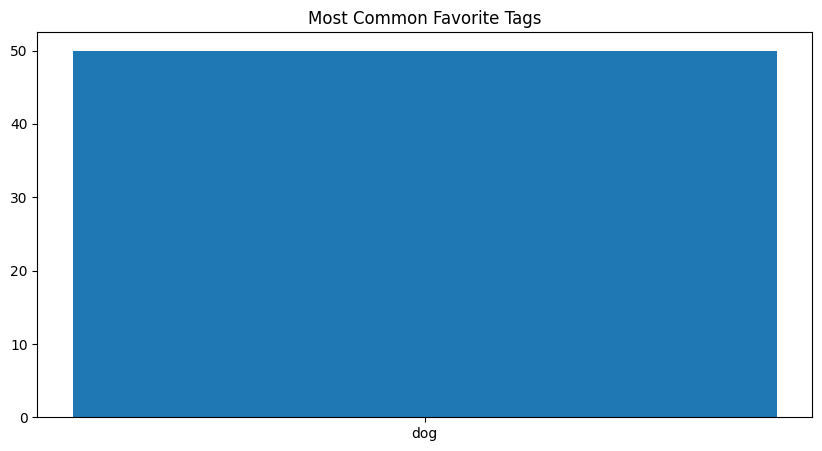

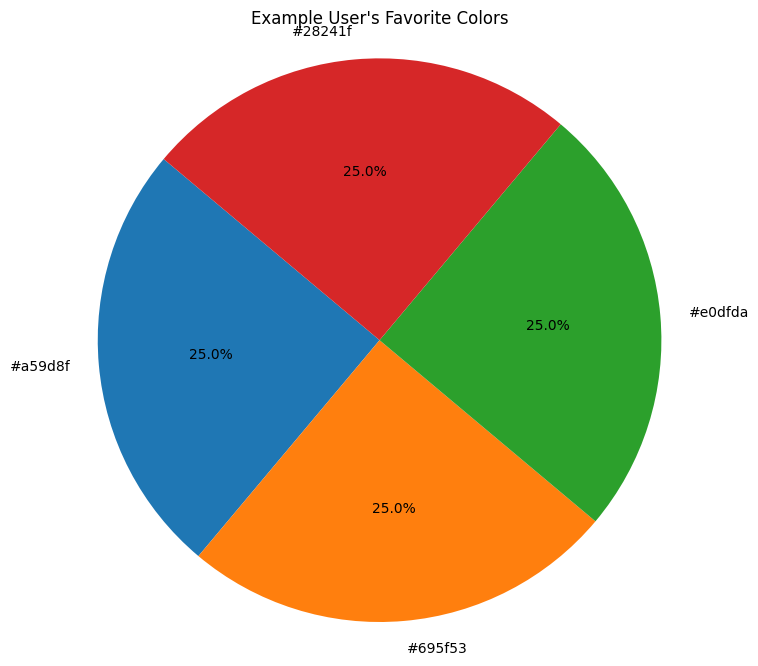

In [8]:
import json
import random
from collections import Counter
import matplotlib.pyplot as plt

# Load the processed image metadata
with open('images/processed_image_metadata.json') as f:
    image_metadata = json.load(f)

# Simulate a number of users
num_users = 10  #Can change

# Define some possible orientations and size categories for the images
orientations = ['Landscape', 'Portrait', 'Square']
size_categories = ['Thumbnail', 'Small', 'Medium', 'Large']

# Function to simulate user preferences
def simulate_user_preferences(image_metadata, num_images=5):
    selected_images = random.sample(image_metadata, num_images)
    favorite_colors = Counter()
    favorite_orientations = Counter()
    favorite_sizes = Counter()
    favorite_tags = Counter()

    for image in selected_images:
        favorite_colors.update(image['dominant_colors'])
        # For the sake of the example, let's randomly assign an orientation and a size
        favorite_orientations.update([random.choice(orientations)])
        favorite_sizes.update([random.choice(size_categories)])
        favorite_tags.update(image['user_tags'])

    # Convert the Counter objects to a dictionary for easy JSON serialization
    user_profile = {
        'favorite_colors': dict(favorite_colors),
        'favorite_orientations': dict(favorite_orientations),
        'favorite_sizes': dict(favorite_sizes),
        'favorite_tags': dict(favorite_tags)
    }
    return user_profile

# Function to plot a bar chart for common preferences
def plot_common_preferences(counter, title):
    labels, values = zip(*counter.most_common())
    indexes = range(len(labels))
    plt.figure(figsize=(10, 5))
    plt.bar(indexes, values, tick_label=labels)
    plt.title(title)
    plt.show()

# Function to plot a pie chart for user profile
def plot_user_profile(profile, title):
    sizes = list(profile.values())
    labels = list(profile.keys())

    plt.figure(figsize=(8, 8))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.title(title)
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.show()


# Create user profiles
user_profiles = [simulate_user_preferences(image_metadata) for _ in range(num_users)]

# Save user profiles to a JSON file
with open('user_profiles.json', 'w') as f:
    json.dump(user_profiles, f, indent=4)

# Example analysis
# Analysis to find the most common preferences across all users
color_counter = Counter()
orientation_counter = Counter()
size_counter = Counter()
tag_counter = Counter()

for profile in user_profiles:
    color_counter.update(profile['favorite_colors'])
    orientation_counter.update(profile['favorite_orientations'])
    size_counter.update(profile['favorite_sizes'])
    tag_counter.update(profile['favorite_tags'])

# Find the most common elements
most_common_color = color_counter.most_common(1)[0]
most_common_orientation = orientation_counter.most_common(1)[0]
most_common_size = size_counter.most_common(1)[0]
most_common_tag = tag_counter.most_common(1)[0]

# Print the most common preferences
print(f"The most common favorite color is: {most_common_color}")
print(f"The most common favorite orientation is: {most_common_orientation}")
print(f"The most common favorite size is: {most_common_size}")
print(f"The most common favorite tag is: {most_common_tag}")

# Print an example user profile
print("\nExample user profile:")
print(json.dumps(random.choice(user_profiles), indent=4))

# Plotting the most common preferences
plot_common_preferences(color_counter, "Most Common Favorite Colors")
plot_common_preferences(orientation_counter, "Most Common Favorite Orientations")
plot_common_preferences(size_counter, "Most Common Favorite Sizes")
plot_common_preferences(tag_counter, "Most Common Favorite Tags")

# Displaying an example user profile with a pie chart
example_user_profile = random.choice(user_profiles)
plot_user_profile(example_user_profile['favorite_colors'], "Example User's Favorite Colors")

Our results here are obviously biased by the fact that we simplified the system tagging color system from an input for each image to an input for all images. Realistically, the system would work the same way if it could tag each image individually and our results would be more accurate and relevant.

DATA VISUALIZATION

Error parsing date for image Kabang-LetsGoHome.jpg: unconverted data remains:  
Error parsing date for image Rags%20the%20Dog%20with%20Sergeant%20George%20E.%20Hickman.jpg: time data '2009:01:30 11:22: 0' does not match format '%Y:%m:%d %H:%M:%S'


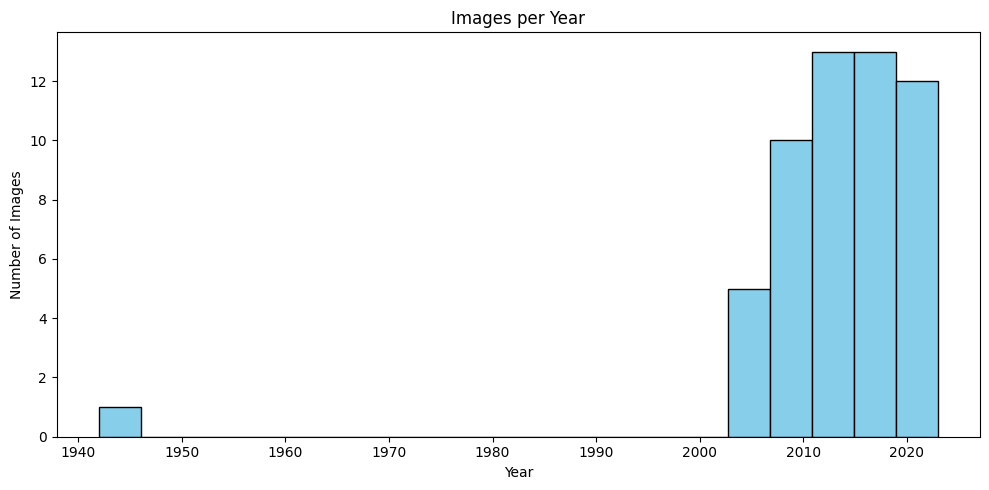

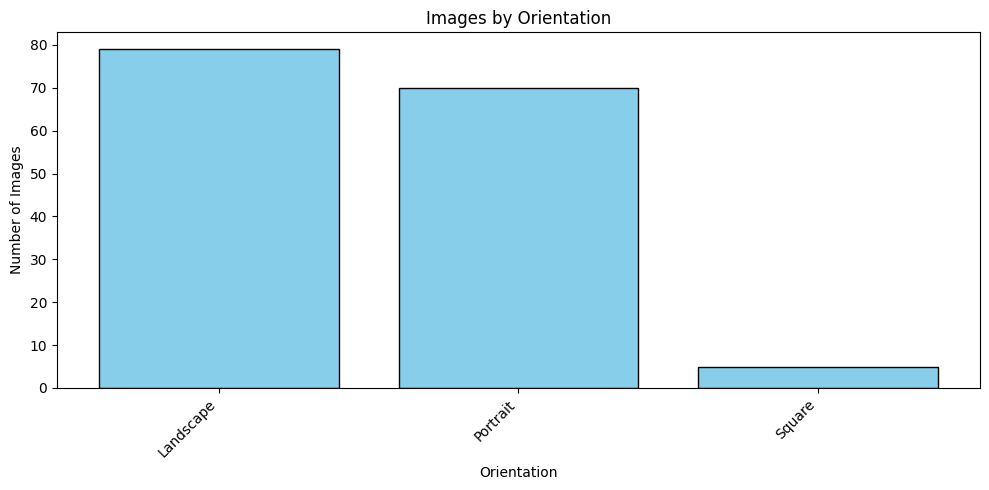

C:\Users\ewanc\AppData\Local\Temp\ipykernel_12572\2784980679.py:45: UserWarning: Glyph 0 ( ) missing from current font.
  plt.tight_layout()
C:\Users\ewanc\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 0 ( ) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


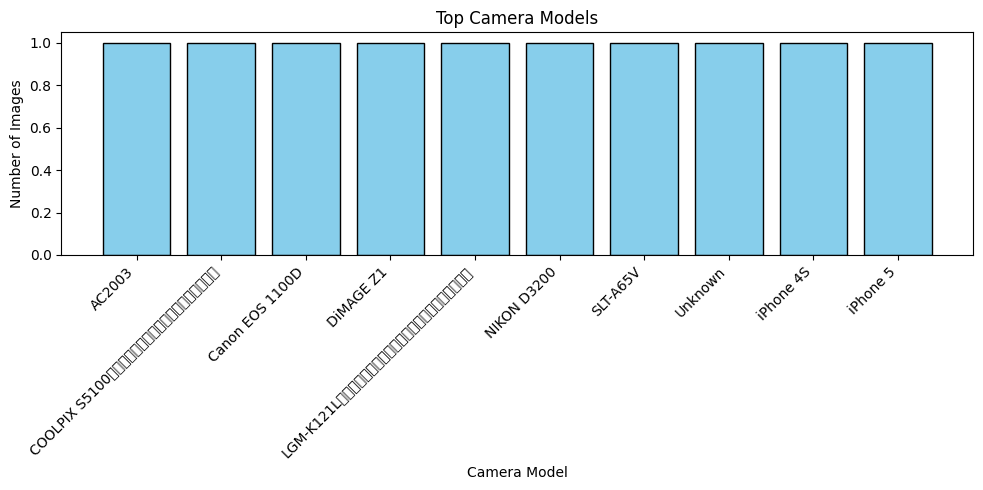

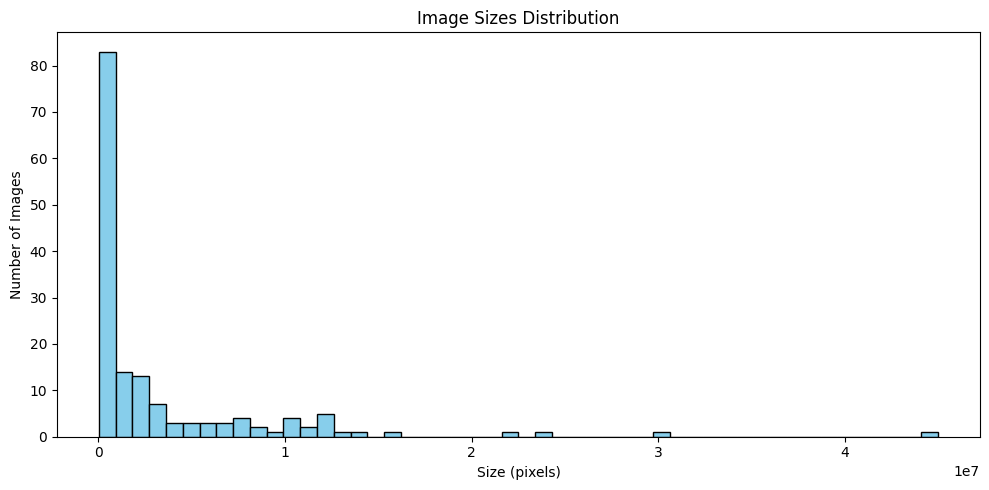

In [15]:
import json
import matplotlib.pyplot as plt
from datetime import datetime

# Load original image metadata
with open('images/image_metadata.json') as f:
    image_metadata = json.load(f)

# Prepare data for plotting
years = []
for img in image_metadata:
    if 'DateTimeOriginal' in img['exif_data']:
        date_str = img['exif_data']['DateTimeOriginal'].strip()  # Remove any trailing whitespace or characters
        try:
            # Attempt to parse the date string and extract the year
            date_obj = datetime.strptime(date_str, '%Y:%m:%d %H:%M:%S')
            years.append(date_obj.year)
        except ValueError as e:
            print(f"Error parsing date for image {img['image_name']}: {e}")
orientations = [img['image_orientation'] for img in image_metadata]
sizes = [(img['image_size'][0]*img['image_size'][1]) for img in image_metadata]
camera_models = [img['exif_data'].get('Model', 'Unknown') for img in image_metadata]

# Function to plot a histogram
def plot_histogram(data, title, xlabel, ylabel='Number of Images'):
    plt.figure(figsize=(10, 5))
    plt.hist(data, bins=len(set(data)), color='skyblue', edgecolor='black')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.show()

# Function to plot a bar chart
def plot_bar_chart(data, title, xlabel, ylabel='Number of Images'):
    counter = Counter(data)
    labels, values = zip(*sorted(counter.items()))
    
    plt.figure(figsize=(10, 5))
    plt.bar(labels, values, color='skyblue', edgecolor='black')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Plot the number of images for every year
plot_histogram(years, 'Images per Year', 'Year')

# Plot the number of images for different orientations
plot_bar_chart(orientations, 'Images by Orientation', 'Orientation')

# Plot the number of images for different camera models (top 10)
top_camera_models = Counter(camera_models).most_common(10)
plot_bar_chart([model for model, count in top_camera_models], 'Top Camera Models', 'Camera Model')

# Plot the image sizes (as a proxy for type) in a histogram
plt.figure(figsize=(10, 5))
plt.hist(sizes, bins=50, color='skyblue', edgecolor='black')
plt.title('Image Sizes Distribution')
plt.xlabel('Size (pixels)')
plt.ylabel('Number of Images')
plt.tight_layout()
plt.show()


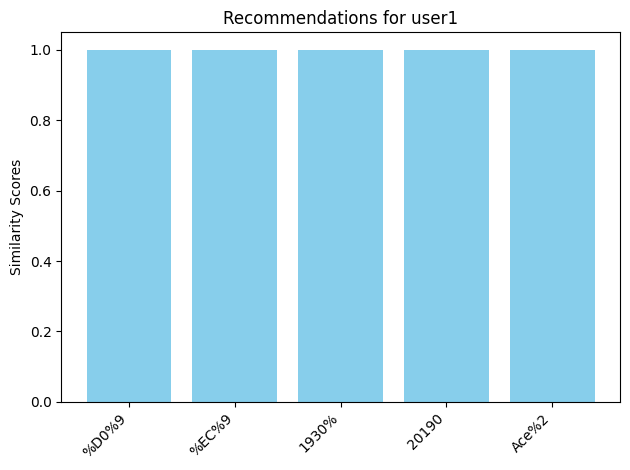

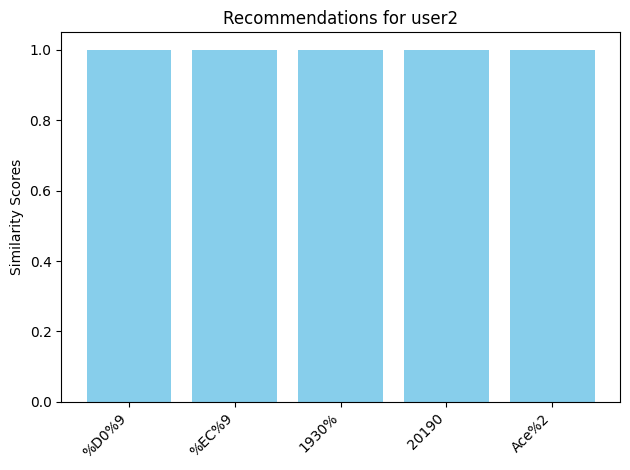

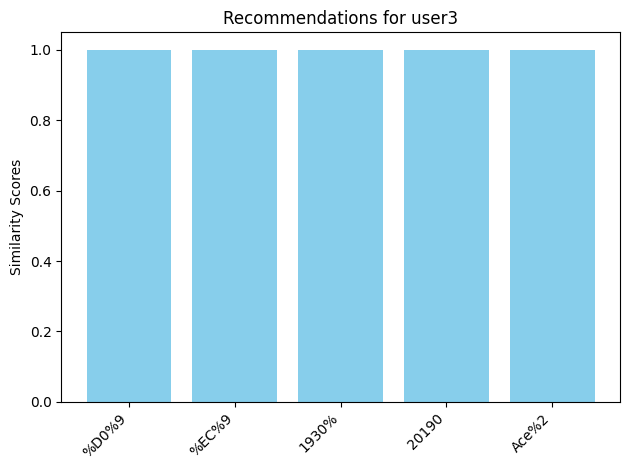

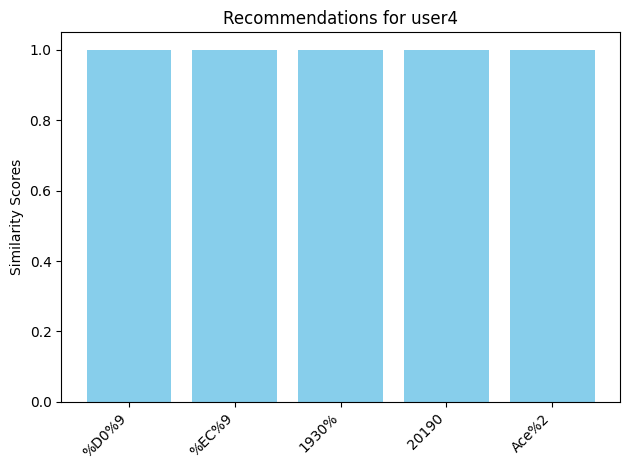

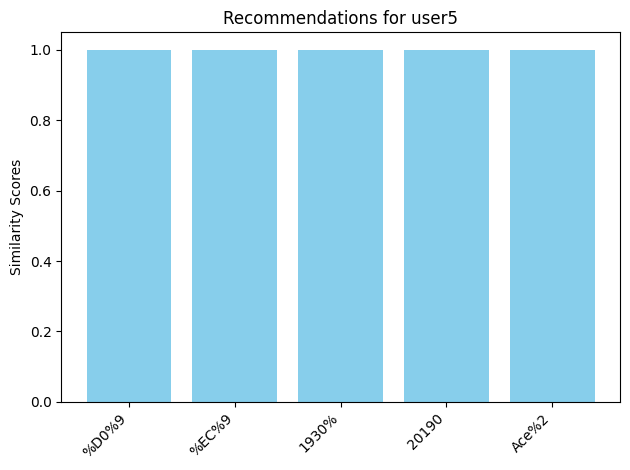

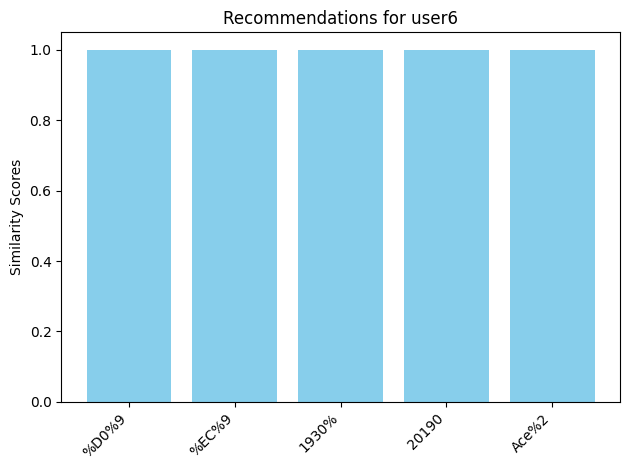

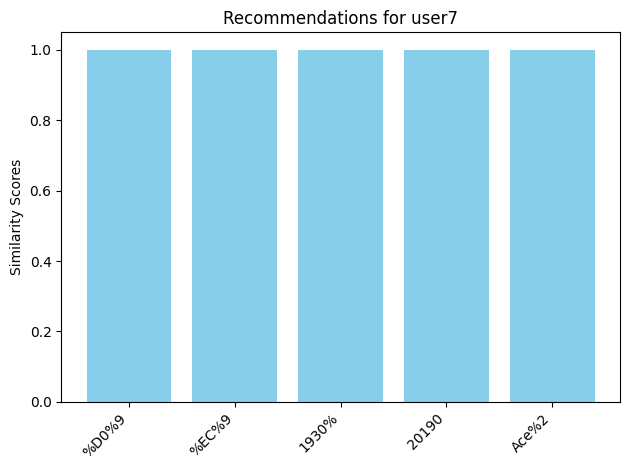

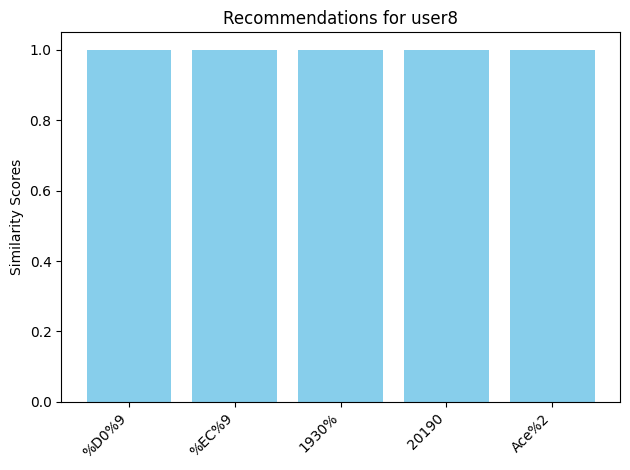

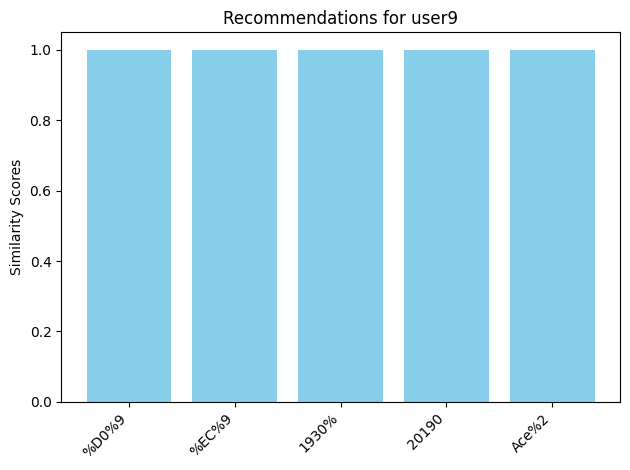

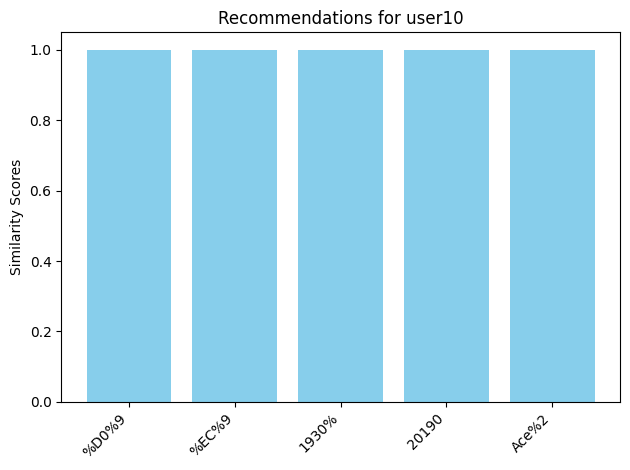

Recommendations for user1 based on their 'likes':
  Image: %D0%92%D0%B8%D0%BA%D0%B8-%D1%8D%D0%BA%D1%81%D0%BA%D1%83%D1%80%D1%81%D0%B8%D1%8F%20%D0%BF%D0%BE%20%D0%9F%D1%83%D1%88%D0%BA%D0%B8%D0%BD%D1%83%2010%20%D0%B0%D0%B2%D0%B3%D1%83%D1%81%D1%82%D0%B0%202019%20%284%29.jpg, Similarity Score: 1.0000
  Image: %EC%98%A4%EC%88%98%EC%9D%98%EA%B2%AC%20%282%29.jpg, Similarity Score: 1.0000
  Image: 1930%20Yalova%20visit.jpg, Similarity Score: 1.0000
  Image: 20190727-DSC00957%20%2848391674722%29.jpg, Similarity Score: 1.0000
  Image: Ace%20The%20Wonder%20Dog.jpg, Similarity Score: 1.0000


Recommendations for user2 based on their 'likes':
  Image: %D0%92%D0%B8%D0%BA%D0%B8-%D1%8D%D0%BA%D1%81%D0%BA%D1%83%D1%80%D1%81%D0%B8%D1%8F%20%D0%BF%D0%BE%20%D0%9F%D1%83%D1%88%D0%BA%D0%B8%D0%BD%D1%83%2010%20%D0%B0%D0%B2%D0%B3%D1%83%D1%81%D1%82%D0%B0%202019%20%284%29.jpg, Similarity Score: 1.0000
  Image: %EC%98%A4%EC%88%98%EC%9D%98%EA%B2%AC%20%282%29.jpg, Similarity Score: 1.0000
  Image: 1930%20Yalova%20visit.j

In [12]:
import json
import random
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import os

# Load processed image metadata
with open('images/processed_image_metadata.json') as f:
    image_metadata = json.load(f)

# Define a function to check if a file is an image
def is_image_file(filename):
    valid_image_extensions = ['.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff', '.webp']
    return any(filename.lower().endswith(ext) for ext in valid_image_extensions)

# Filter out non-image files from metadata
image_metadata = [img for img in image_metadata if is_image_file(img['image_name'])]

# Function to build feature vectors for images based on dominant colors
def build_feature_vector(hex_color):
    return np.array([int(hex_color[i:i+2], 16) for i in (1, 3, 5)]) / 255

# Build image feature vectors
image_features = {
    image['image_name']: np.mean([build_feature_vector(color) for color in image['dominant_colors']], axis=0)
    for image in image_metadata
}

# Simulate user "likes" by randomly selecting 4 images for each user
num_users = 10
user_likes = {
    f'user{i+1}': random.sample(list(image_features.keys()), 4) for i in range(num_users)
}

# Recommend images to a user based on color similarity of the images they "liked"
def recommend_images(liked_images, image_features):
    # Aggregate the feature vectors of the liked images
    liked_features = np.mean([image_features[img] for img in liked_images], axis=0)
    
    # Calculate the similarity with all other images
    similarities = {
        img_name: cosine_similarity([liked_features], [features])[0][0]
        for img_name, features in image_features.items() if img_name not in liked_images
    }
    
    # Sort images by similarity score in descending order
    return sorted(similarities.items(), key=lambda item: item[1], reverse=True)[:5]

# Recommend images for each user
user_recommendations = {
    user: recommend_images(likes, image_features) for user, likes in user_likes.items()
}

# Plot recommendations for each user
for user, recommendations in user_recommendations.items():
    # Unpack the image names and similarity scores
    image_names, similarity_scores = zip(*recommendations)
    
    # Shorten the image names to the first 5 characters for display
    short_image_names = [name[:5] for name in image_names]
    
    # Create the bar chart
    fig, ax = plt.subplots()
    ax.bar(range(len(image_names)), similarity_scores, color='skyblue')
    
    # Add some text for labels, title, and axes ticks
    ax.set_ylabel('Similarity Scores')
    ax.set_title(f'Recommendations for {user}')
    ax.set_xticks(range(len(image_names)))
    ax.set_xticklabels(short_image_names, rotation=45, ha='right')
    
    # Show the plot
    plt.tight_layout()  # Adjust the plot to ensure everything fits without overlapping
    plt.show()

# Display recommendations for each user
for user, recommendations in user_recommendations.items():
    print(f"Recommendations for {user} based on their 'likes':")
    for img_name, score in recommendations:
        print(f"  Image: {img_name}, Similarity Score: {score:.4f}")
    print("\n")


here we are using collaborative filtering recommendation for our system. We are using the likes of one user to recommend him similar images in color to those he liked. It is better way to recommend images than content simply content-based recommendation since this is based on the behavior of the users.

Of course here, our similarity scores are biased by our simplification of the colors tags since all images have the same tags. In a real system, the tags would be different for each image and the similarity scores would be more accurate. However, the similarity score could also be based on other criterias such as the size of the image, the type of the image, the date of the image, etc.